## **70010 - Computational Neurodynamics: Coursework**

---

In [1]:
from iznetwork import IzNetwork
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [63]:
class Small_World_Modular_Net(object):
    """
    This Class simulates a Small World Modular Network of Izhikevich Neurons. 
        - the number of nodes n
        - number of edges m
        - number of modules C
        - probability of rewiring p
    """

    def __init__(self, p, n=1000, C=8, m=1000):
        """
        Initialize the Small World Modular Network with n neurons grouped into C modules, each with m edges, and Network rewiring probability p.
        Inputs:
            - p -- Rewiring Probability
            - n -- Number of total Neurons in the Network (Defaults to 1000). Automatically dives into 80% excitatory and 20% inhibitory neurons.
            - C -- Number of Communities (Defaults to 8)
            - m -- Number of Edges per Module (Defaults to 1000)
        """
        # network parameters
        self._num_neurons = n
        self._D = np.zeros((n, n)) # Initialize Delays
        self._W = np.zeros((n, n)) # Initialize Weight Connections

        # indices of each neuron type
        self._excitatory = [i for i in range(int(n * 0.8))] # indices [0,800) = excitatory neurons
        inhibitory_offset = len(self._excitatory)
        self._inhibitory = [(i + inhibitory_offset) for i in range(int(n * 0.2))] # indices [800,1000) = excitatory neurons

        # connection matrix --> n x n: each (n_i, n_j) entry represents the directed connection from neuron i to neuron j
        self._connections = np.zeros((n, n))
        # C communities of n//C excitatory neurons, where each entry (C_k, n_i, n_j) represents the edge from the i-th to the j-th excitatory neurons in k-th community 
        # EG: (3, 307, 385) = 1, if the 307th neuron in 3rd community conects to the 385th neuron in the same community
        #     (3, 307, 385) = 0, otherwise  
        neuro_per_module = len(self._excitatory)//C
        self._num_modules = C
        self._communities = np.zeros((self._num_modules, neuro_per_module, neuro_per_module))
        self._set_excitatory(m, neuro_per_module=neuro_per_module)
        self._set_inhibitory(exc_to_inhib=4, neuro_per_module=neuro_per_module)
        # ensure no self-connections
        for i in range(n):
            if self._connections[i, i] != 0:
                # print(f"WARNING: Self connection for neuron {i}")
                self._connections[i, i] = 0
        self.assert_connections(neuro_per_module)

        self._p = p # rewiring probability
        self._rewire(p, neuro_per_module=neuro_per_module)

        # scale connections
        self._W = self._scale_connections(self._connections, inhibitory_offset=inhibitory_offset)
        self._set_delays(inhibitory_offset=inhibitory_offset)   

        # create network
        self._net = IzNetwork(N=n, Dmax=50)
        self._net.setDelays(self._D.astype(int))
        self._net.setWeights(self._W)
        a,b,c,d = self._set_params(inhibitory_offset=inhibitory_offset)
        self._net.setParameters(a,b,c,d)


    def _set_excitatory(self, m, neuro_per_module):
        # set 1000 random directed connections between excitatory neurons within 
        # the same community (for each module)
        for module in range(self._num_modules):
            set_edges = 0
            connections = []
            offset = module * neuro_per_module
            while set_edges < m:
                source_neuro = np.random.randint(0, neuro_per_module)
                target_neuro = np.random.randint(0, neuro_per_module)
                if (source_neuro != target_neuro) and ((source_neuro, target_neuro) not in connections):
                    self._communities[module, source_neuro, target_neuro] = 1
                    self._connections[source_neuro+offset, target_neuro+offset] = 1
                    connections.append((source_neuro, target_neuro))
                    set_edges += 1
            # assert sum(self._communities[module, from_neuron, :]) == m, f"Number of community connections for neuron {from_neuron} in community {module} not equal to {m}"


    def _set_inhibitory(self, exc_to_inhib, neuro_per_module):
        for inhib in self._inhibitory:
            set_edges = 0
            connections = []
            source_module = np.random.randint(self._num_modules)
            while set_edges < exc_to_inhib:
                start_neuro = source_module * neuro_per_module
                end_neuro = start_neuro + neuro_per_module
                excitatory_source = np.random.randint(start_neuro, end_neuro)
                if (excitatory_source, inhib) not in connections:
                    self._connections[excitatory_source, inhib] = np.random.uniform(0, 1)
                    connections.append((excitatory_source, inhib))
                    set_edges += 1
            self._connections[inhib, :] = np.random.uniform(-1, 0, self._num_neurons) # each inhibitrory neuron connects to every neuron
            self._connections[inhib, inhib] = 0 # except itself
            # assert sum(self._connections[:, inhib]) == exc_to_inhib, f"Number of excitatory to inhibitory connections not equal to {exc_to_inhib} for neuron {inhib}"


    def _scale_connections(self, connections, inhibitory_offset):
        W = np.copy(connections)
        # Apply scaling factor to the weights
        W[:inhibitory_offset, :inhibitory_offset] *= 17 # Excitatory to Excitatory
        W[:inhibitory_offset, inhibitory_offset:] *= 50 # Excitatory to Inhibitory
        W[inhibitory_offset:, :inhibitory_offset] *= 2  # Inhibitory to Excitatory
        return W


    def _set_delays(self, inhibitory_offset):
        # [0,800) excitatory, [800,1000) inhibitory
        self._D[:inhibitory_offset, :inhibitory_offset] = np.random.randint(1, 20, (inhibitory_offset, inhibitory_offset)) # Excitatory to Excitatory
        self._D[:inhibitory_offset, inhibitory_offset:] = 1 # Excitatory to Inhibitory
        self._D[inhibitory_offset:, :inhibitory_offset] = 1 # Inhibitory to Excitatory
        self._D[inhibitory_offset:, inhibitory_offset:] = 1 # Inhibitory to Inhibitory


    def _rewire(self, p, neuro_per_module):
        # Get the connections from the set intra_edges
        for module in range(self._num_modules):
            offset = module * neuro_per_module
            intra_connection = np.argwhere(self._communities[module] > 0) # Evaluate each existing intra community connection
            for connection in intra_connection:
                if np.random.rand() < p:
                    # Remove the intra connection
                    source_neuro = connection[0]+offset
                    # delete connection
                    self._connections[connection[0]+offset, connection[1]+offset] = 0
                    self._communities[module, connection[0], connection[1]] = 0
                    # Add a new connection (anything outside the module)
                    target_neuro = np.random.randint(0, len(self._excitatory))
                    target_module = target_neuro // neuro_per_module
                    # if the new neuron is in the same module, keep generating a new neuron
                    while target_module == module:
                        target_neuro = np.random.randint(0, len(self._excitatory))
                        target_module = target_neuro // neuro_per_module

                    # print(f"remove connection from {connection[0]+offset} to {connection[1]+offset}")
                    # print(f"rewire connection from {source_neuro} to {target_neuro} in module {target_module}")
                    self._connections[source_neuro, target_neuro] = 1
    

    def _set_params(self, inhibitory_offset):
        r = np.random.rand(self._num_neurons)

        a = np.zeros(self._num_neurons)
        a[inhibitory_offset:] = 0.02 + (0.08 * r[inhibitory_offset:]) # inhibitory
        a[:inhibitory_offset] = 0.02 # excitatory 
        b = np.zeros(self._num_neurons)
        b[inhibitory_offset:] = 0.25 - (0.05 * r[inhibitory_offset:]) # inhibitory
        b[:inhibitory_offset] = 0.2 # excitatory 
        c = np.zeros(self._num_neurons)
        c[inhibitory_offset:] = -65 # inhibitory
        c[:inhibitory_offset] = -65 + (15 * (r[:inhibitory_offset] ** r[:inhibitory_offset])) # excitatory 
        d = np.zeros(self._num_neurons)
        d[inhibitory_offset:] = 2 # inhibitory
        d[:inhibitory_offset] = 8 - (6 * (r[:inhibitory_offset] ** r[:inhibitory_offset])) # excitatory 

        return (a,b,c,d)


    def assert_connections(self, neuro_per_module=100):
        intra_edges = 1000
        inhib_offset = 800
        exc_to_inhib = 4
        inhib_to_all = intra_edges-1

        for neuro in range(self._num_neurons):
            module = neuro // neuro_per_module
            if neuro in self._excitatory:
                # assert np.sum(self._connections[neuro, :]) <= intra_edges+exc_to_inhib, f"Too many connections for neuron {neuro}"
                assert np.sum(self._communities[module, :, :]) == intra_edges, f"Number of community connections in community {module} not equal to {intra_edges}"
                assert np.sum(self._communities[module, :, inhib_offset:]) <= 4, f"Too many connections from community {module} to inhibitory neurons"
            elif neuro in self._inhibitory:
                assert np.count_nonzero((self._connections[:inhib_offset, neuro])) == exc_to_inhib, f"Number of incoming excitatory connections for neuron {neuro} not equal to {exc_to_inhib}"
                assert np.count_nonzero((self._connections[neuro, :])) == inhib_to_all, f"Number of outgoing inhibitory connections for neuron {neuro} not equal to {inhib_to_all}"
            assert (self._connections[neuro, neuro] == 0), f"Self connection for neuron {neuro}"
        print(f"All Network Connections are Valid.")


    def simulate_net(self, T=1000):
        # Simulate the network for 1000ms
        V = np.zeros((T, self._num_neurons))
        fired = np.zeros((T, self._num_neurons))
        for t in range(1000):
            # For each neuron in the net, we use a poisson process with lambda = 0.01 to inject I=15
            I = np.zeros(self._num_neurons)
            I = np.random.poisson(0.01, self._num_neurons) * 15
            self._net.setCurrent(I)
            fired_ids = self._net.update()
            V[t,:], _ = self._net.getState()
            for id in fired_ids:
                fired[t, id] = 1
        # (fired == 0).all()

        # plot raster plot
        plt.figure()
        plt.imshow(fired.T, aspect='auto', cmap='binary')
        plt.xlabel('Time (ms)')
        plt.ylabel('Neuron')
        plt.title(f'Raster plot for Net with p={self._p}')
        plt.show()

        # Plot the rolling mean (for each module) with a window of 50ms
        # Downsample  the  firing  rates  to  obtain  the  mean  by  computing  the  average  number  of 
        # firings in 50ms windows shifted every 20ms. (This should yield 50 data points for each module.)
        time_array = np.arange(0, T, 20)
        plt.figure(figsize=(15, 5))

        for i in range(self._num_modules):
            module = np.arange(200 + i*100, 200 + i*100 + 100)
            mean_firing_rate = np.zeros(50)
            for t in range(50):
                t_real = t * 20
                mean_firing_rate[t] = np.mean(fired[t_real-24:t_real+25, module])
            plt.plot(time_array, mean_firing_rate, label='Module {}'.format(i+1))

        plt.xlabel('Time (ms)')
        plt.ylabel('Firing rate')
        plt.title(f'Rolling Mean Firing Rate for each module in Net with p={self._p}')
        plt.legend()
        plt.show()


    def plot_weights(self, title):
        # visualize w as heatmap
        plt.figure(figsize=(8,8))
        sns.heatmap(self._W !=0, cmap='binary', cbar=False,)
        # sns.heatmap(W_p[p], cmap='gray')
        plt.xticks(np.arange(0, 1000, 100), np.arange(0, 1000, 100))
        plt.yticks(np.arange(0, 1000, 100), np.arange(0, 1000, 100))
        plt.title(title)
        # plt.savefig('test.png', dpi=500)
        plt.show()



In [64]:
# Create networks for each p
p = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
networks_by_p = []
for i in range(len(p)):
    print(f"Network with p={p[i]}")
    networks_by_p.append(Small_World_Modular_Net(p=p[i]))

Network with p=0
All Network Connections are Valid.
Network with p=0.1
All Network Connections are Valid.
Network with p=0.2
All Network Connections are Valid.
Network with p=0.3
All Network Connections are Valid.
Network with p=0.4
All Network Connections are Valid.
Network with p=0.5
All Network Connections are Valid.


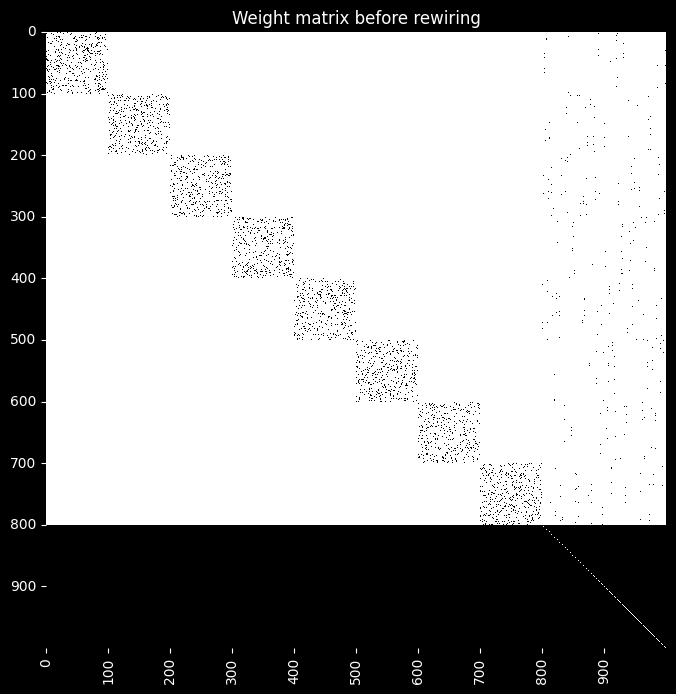

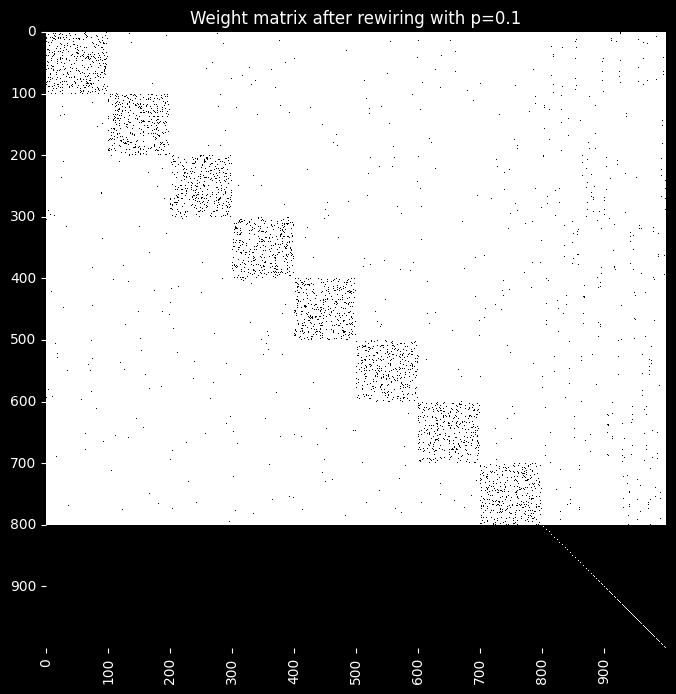

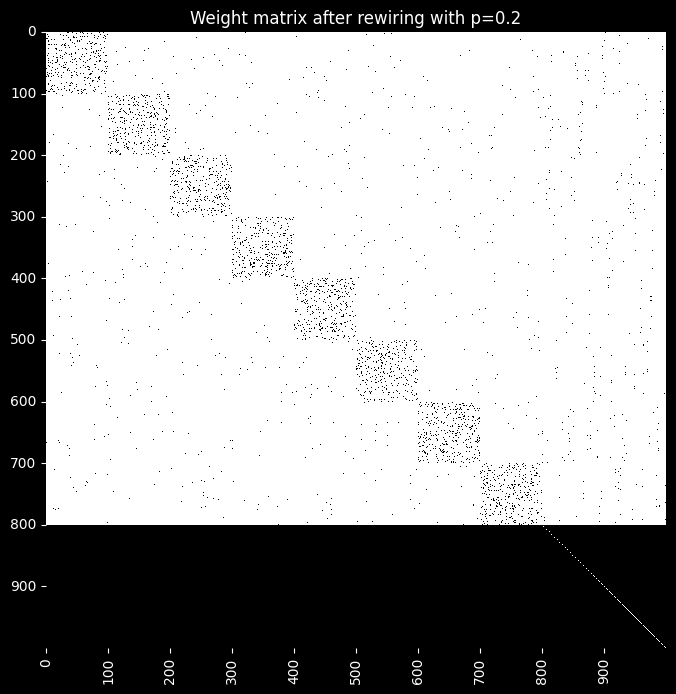

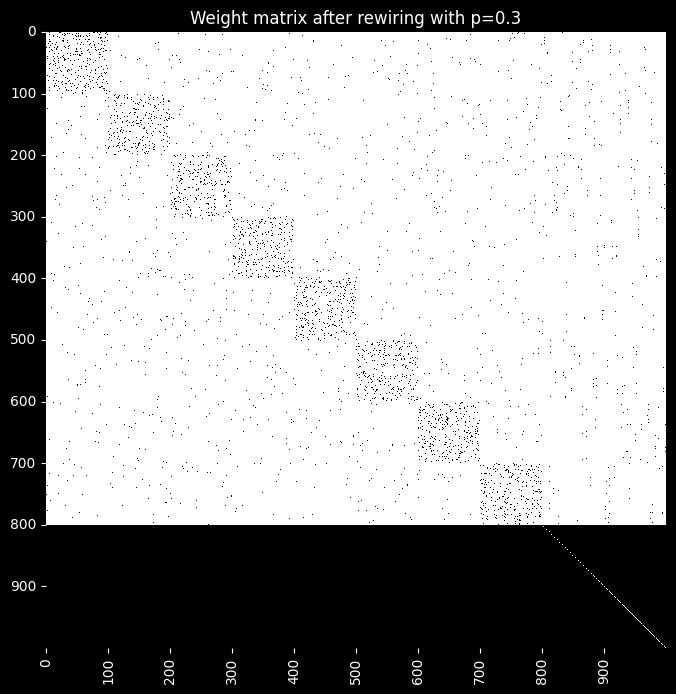

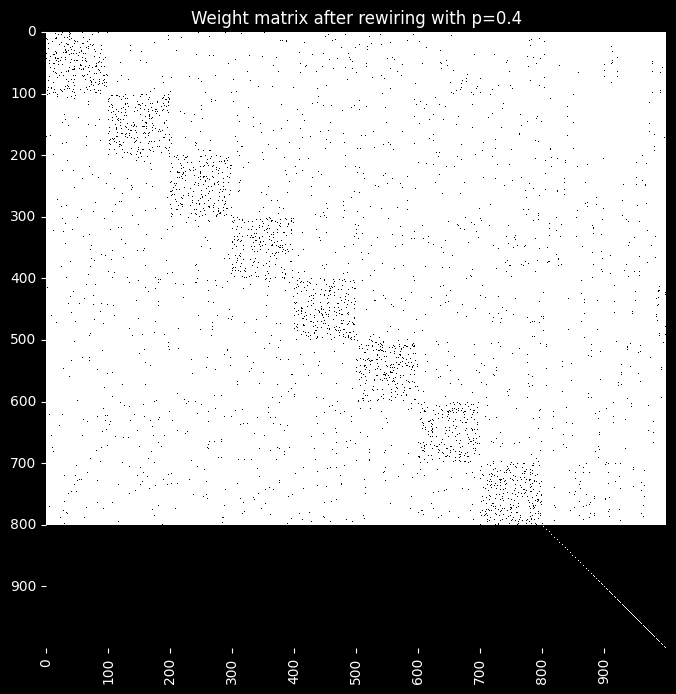

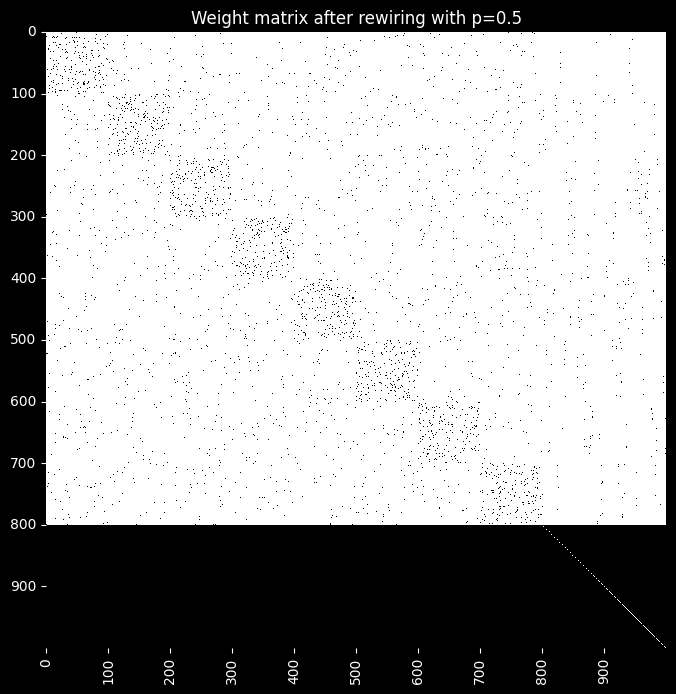

In [65]:
# a) Plot the weight matrix of the network before and after rewiring for each p
for net in networks_by_p:
    if net._p==0.0:
        net.plot_weights("Weight matrix before rewiring")
    else: 
        net.plot_weights(f"Weight matrix after rewiring with p={net._p}")

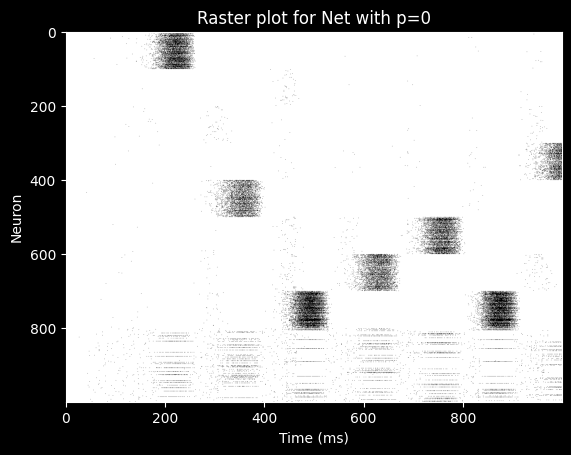

/Users/asiabelfiore/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/asiabelfiore/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


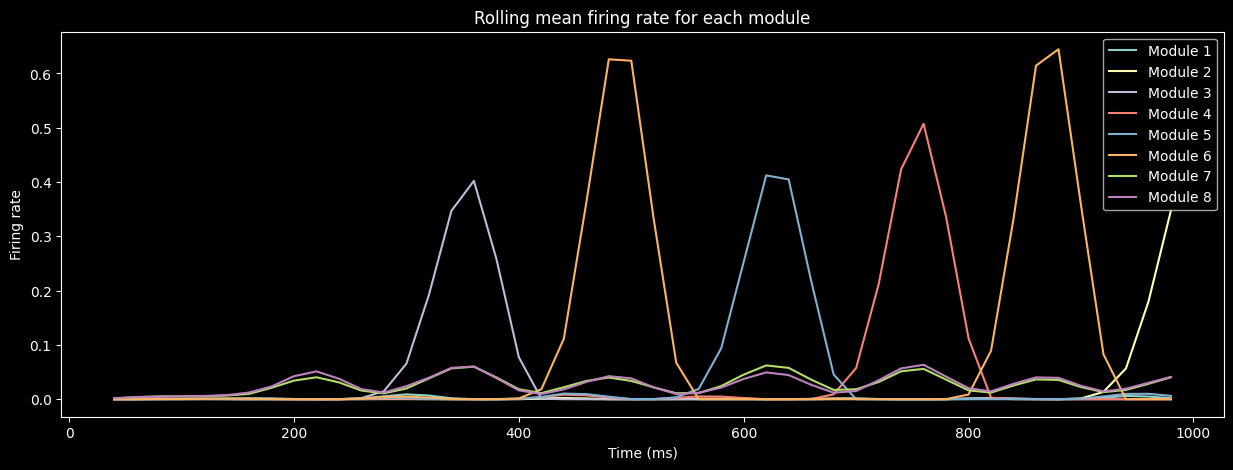

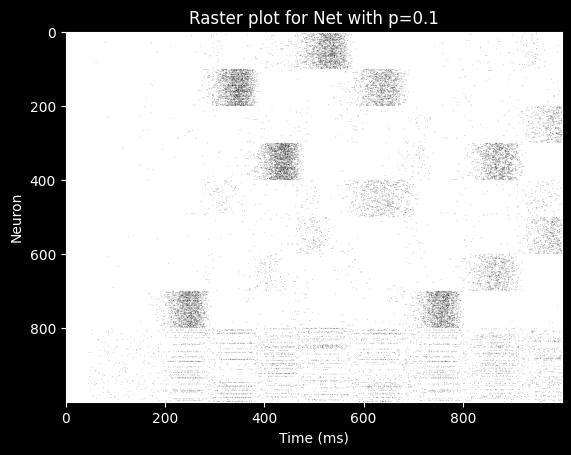

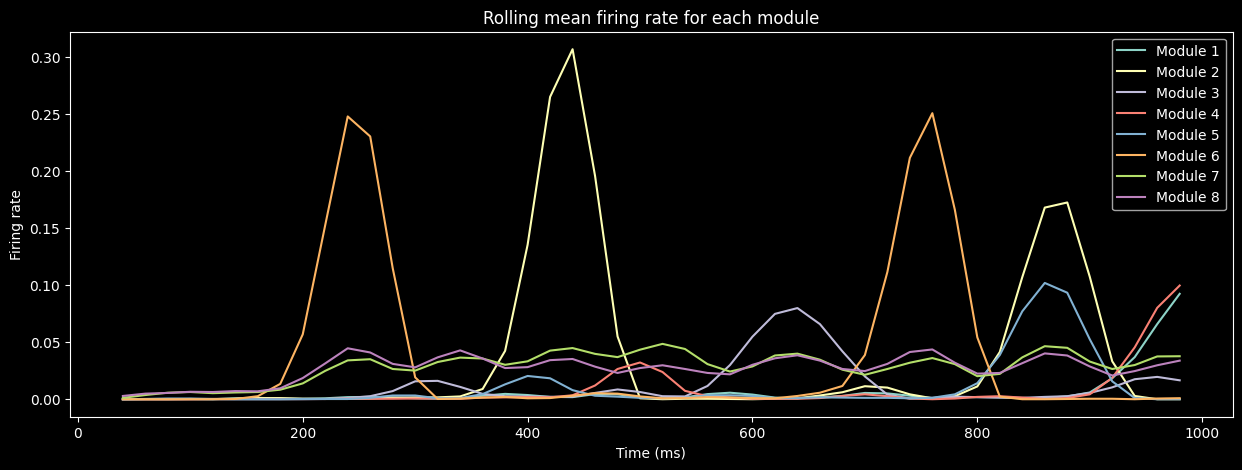

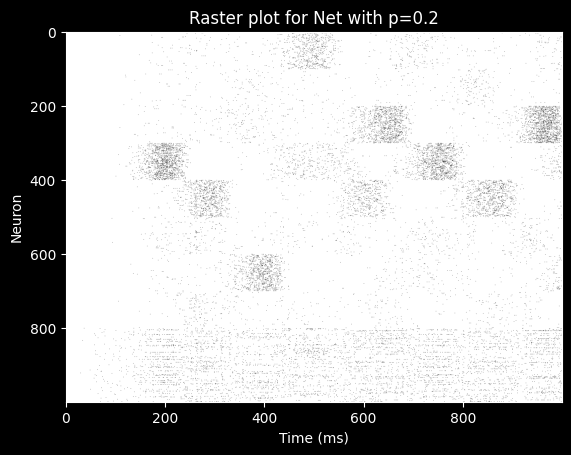

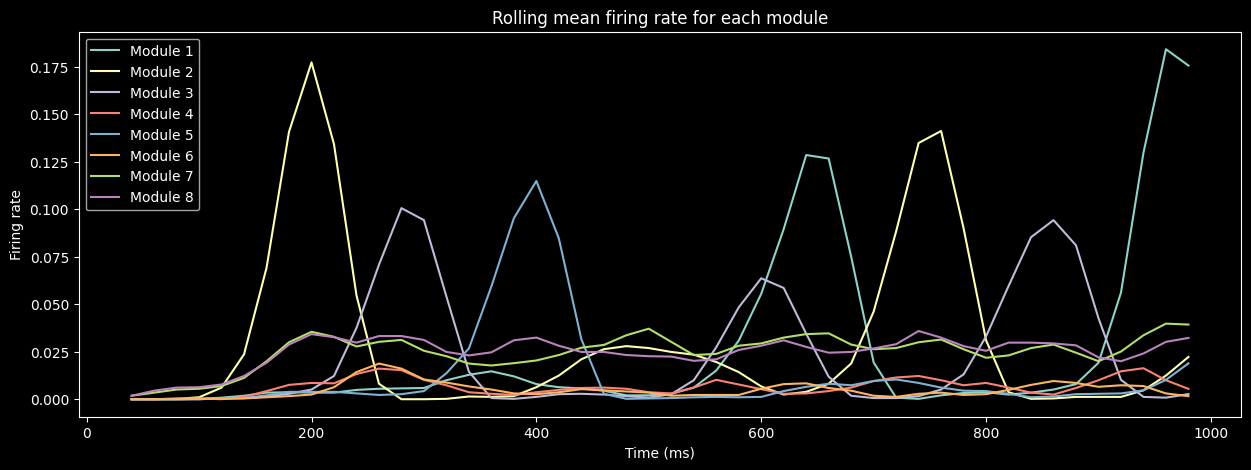

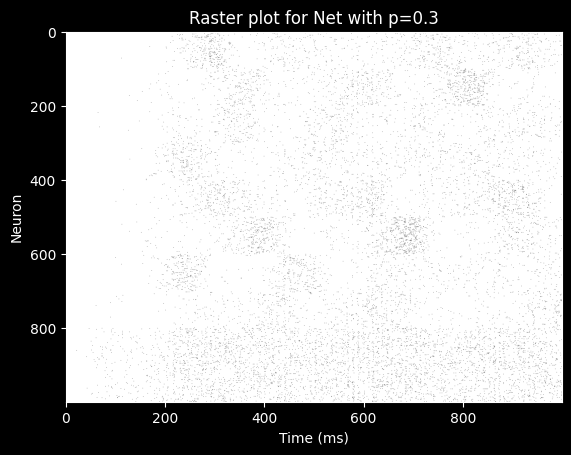

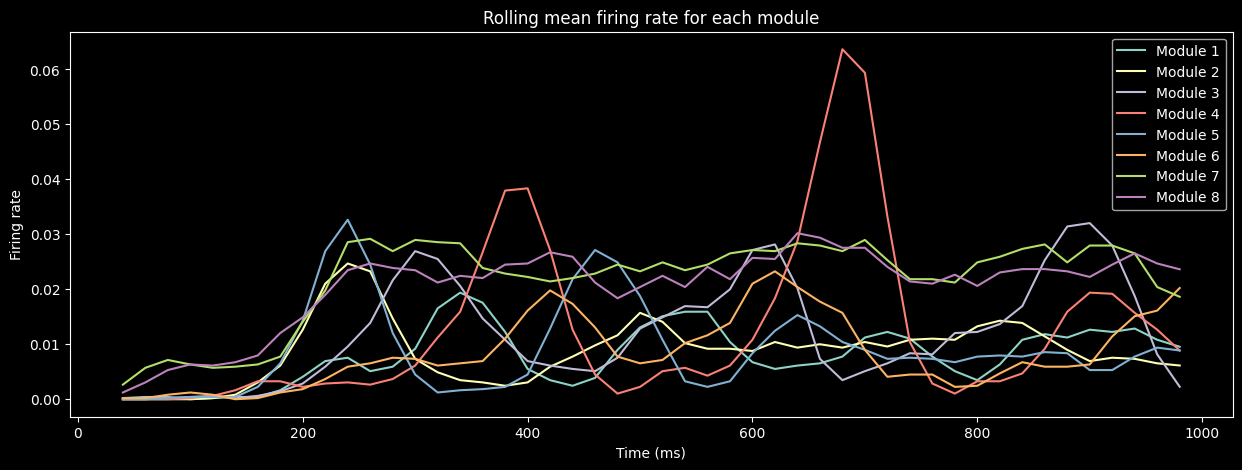

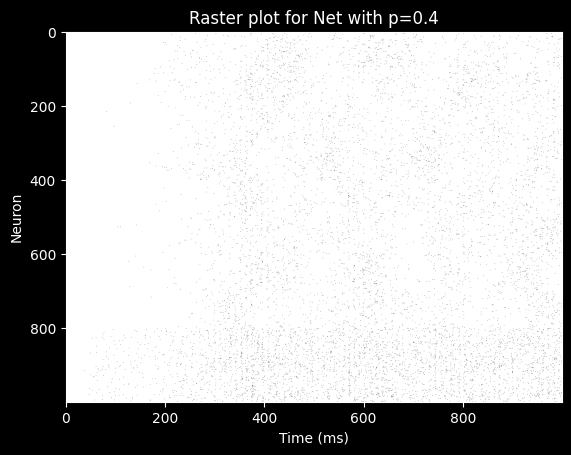

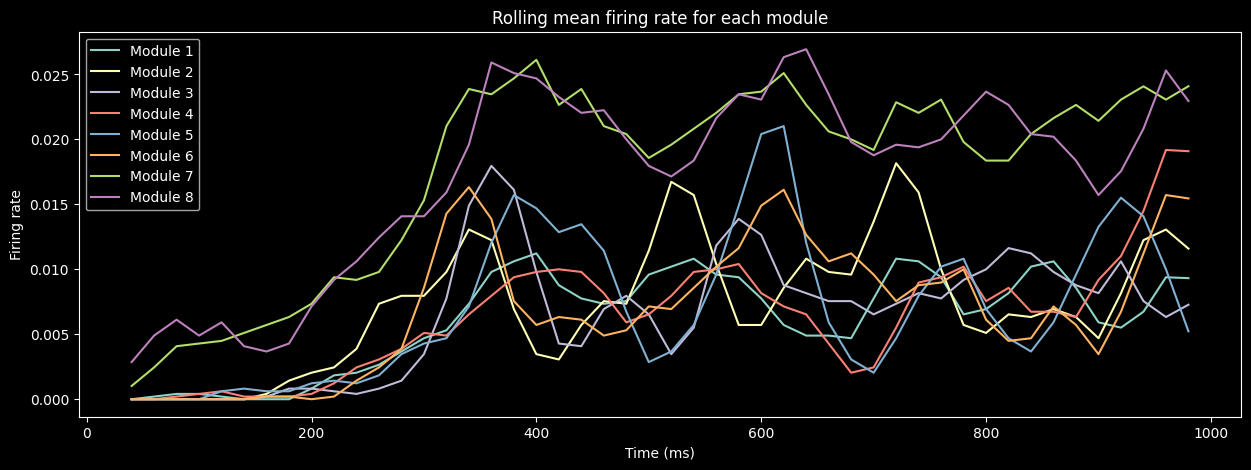

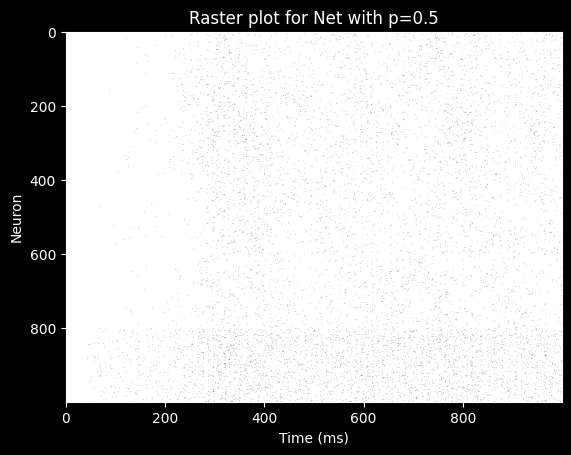

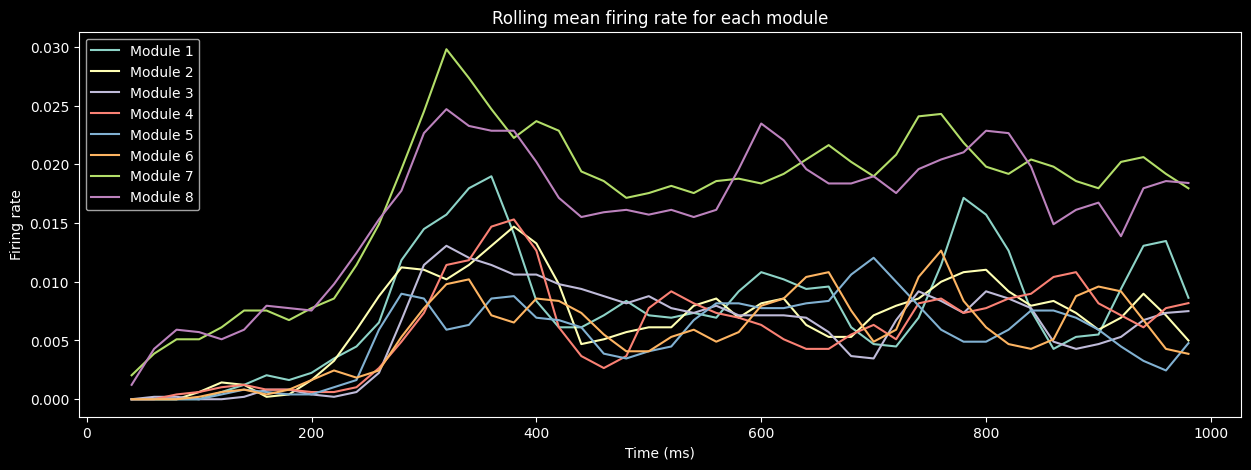

In [ ]:
# b-c) Plot firing activity of each network and of each module for 1000ms
for net in networks_by_p:
    net.simulate_net(T=1000)